In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore')

In [56]:
from tqdm import tqdm
from torch import nn, optim

In [22]:
data = pd.read_csv('Data/covid_data.csv', index_col = 0)
data.head()

,연번,환자,확진일,거주지,여행력,접촉력,퇴원현황,년,월,일,주,거리두기
76,324,8816,2020-03-21,서초구,-,감염경로 조사중,퇴원,2020,3,21,12,0.0
77,323,8826,2020-03-21,서대문구,-,감염경로 조사중,퇴원,2020,3,21,12,0.0
78,322,8881,2020-03-21,서대문구,유럽,해외유입,퇴원,2020,3,21,12,0.0
79,321,8836,2020-03-21,영등포구,유럽,해외유입,퇴원,2020,3,21,12,0.0
80,320,8848,2020-03-21,성동구,-,감염경로 조사중,퇴원,2020,3,21,12,0.0


In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 203100 entries, 76 to 72
Data columns (total 12 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   연번      203100 non-null  int64  
 1   환자      203100 non-null  int64  
 2   확진일     203100 non-null  object 
 3   거주지     203100 non-null  object 
 4   여행력     203100 non-null  object 
 5   접촉력     203100 non-null  object 
 6   퇴원현황    148547 non-null  object 
 7   년       203100 non-null  int64  
 8   월       203100 non-null  int64  
 9   일       203100 non-null  int64  
 10  주       203100 non-null  int64  
 11  거리두기    203100 non-null  float64
dtypes: float64(1), int64(6), object(5)
memory usage: 20.1+ MB


In [33]:
print('데이터의 {} 행 과 {} 열 '.format(data.shape[0],data.shape[1]))

데이터의 203100 행 과 12 열 


In [24]:
def check_missing_col(dataframe):
    missing_col = []
    for col in dataframe.columns:
        missing_values = sum(dataframe[col].isna())
        is_missing = True if missing_values >= 1 else False
        if is_missing:
            print(f'결측치가 있는 컬럼은: {col} 입니다')
            print(f'해당 컬럼에 총 {missing_values} 개의 결측치가 존재합니다.')
            missing_col.append([col, dataframe[col].dtype])
    if missing_col == []:
        print('결측치가 존재하지 않습니다')
    return missing_col

missing_col = check_missing_col(data)

결측치가 있는 컬럼은: 퇴원현황 입니다
해당 컬럼에 총 54553 개의 결측치가 존재합니다.


### 데이터셋 준비

In [34]:
time_series_data = pd.DataFrame(data['확진일'].value_counts().sort_values(), )
time_series_data.rename(columns={'확진일' :'확진자수'})
time_series_data.head()

2020-04-15       1
2020-05-17       1
2020-04-19       1
2020-04-24       1
2020-05-01       1
              ... 
2021-12-10    2835
2021-12-16    2846
2021-12-07    2900
2021-12-15    3056
2021-12-14    3166
Name: 확진일, Length: 638, dtype: int64

In [37]:
# 시계열 데이터 변환 

def sequences(d, seq_length) :
    xs = []
    ys = []
    
    for i in range(len(d) - seq_length) :
        x = d.iloc[i : (i+seq_length)]
        y = d.iloc[i+ seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 5

X, y = sequences(time_series_data, seq_length)

In [38]:
X.shape, y.shape

((633, 5), (633,))

In [39]:
# train 데이터를 70%로 가져가고 validation 과 test를 각각 15% 씩 가져감
train_size = int(633 * 0.7)
print(train_size)

443


In [41]:
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+100], y[train_size:train_size+100]
X_test, y_test = X[train_size+100:], y[train_size+100:]

In [42]:
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(443, 5) (100, 5) (90, 5)
(443,) (100,) (90,)


### 스케일링

In [45]:
MIN = X_train.min()
MAX = X_train.max()
print(MIN, MAX)

1 298


In [46]:
def MinMaxScale(array, min, max):

    return (array - min) / (max - min)

In [47]:
X_train = MinMaxScale(X_train, MIN, MAX)
y_train = MinMaxScale(y_train, MIN, MAX)
X_val = MinMaxScale(X_val, MIN, MAX)
y_val = MinMaxScale(y_val, MIN, MAX)
X_test = MinMaxScale(X_test, MIN, MAX)
y_test = MinMaxScale(y_test, MIN, MAX)

In [48]:
# Pytorch 형태로 변환

def make_Tensor(array):
    return torch.from_numpy(array).float()

In [49]:
X_train = make_Tensor(X_train)
y_train = make_Tensor(y_train)
X_val = make_Tensor(X_val)
y_val = make_Tensor(y_val)
X_test = make_Tensor(X_test)
y_test = make_Tensor(y_test)

In [57]:
class CovidPredictor(nn.Module):
    def __init__(self, n_features, n_hidden, seq_len, n_layers):
        super(CovidPredictor, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            num_layers=n_layers
        )
        self.linear = nn.Linear(in_features=n_hidden, out_features=1)
    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
        )
    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(
            sequences.view(len(sequences), self.seq_len, -1),
            self.hidden
        )
        last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
        return y_pred

In [58]:
def train_model(model, train_data, train_labels, val_data=None, val_labels=None, num_epochs=100, verbose = 10, patience = 10):
    loss_fn = torch.nn.L1Loss() #
    optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
    train_hist = []
    val_hist = []
    for t in range(num_epochs):

        epoch_loss = 0

        for idx, seq in enumerate(train_data): 

            model.reset_hidden_state() # seq 별 hidden state reset

            # train loss
            seq = torch.unsqueeze(seq, 0)
            y_pred = model(seq)
            loss = loss_fn(y_pred[0].float(), train_labels[idx]) # 1개의 step에 대한 loss

            # update weights
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

            epoch_loss += loss.item()
        
        train_hist.append(epoch_loss / len(train_data))

        if val_data is not None:

            with torch.no_grad():

                val_loss = 0

                for val_idx, val_seq in enumerate(val_data):

                    model.reset_hidden_state() # seq 별로 hidden state 초기화 

                    val_seq = torch.unsqueeze(val_seq, 0)
                    y_val_pred = model(val_seq)
                    val_step_loss = loss_fn(y_val_pred[0].float(), val_labels[val_idx])

                    val_loss += val_step_loss
                
            val_hist.append(val_loss / len(val_data)) # val hist에 추가
            
            ## verbose 번째 마다 loss 출력 
            if t % verbose == 0:
                print(f'Epoch {t} train loss: {epoch_loss / len(train_data)} val loss: {val_loss / len(val_data)}')

            ## patience 번째 마다 early stopping 여부 확인
            if (t % patience == 0) & (t != 0):
                
                ## loss가 커졌다면 early stop
                if val_hist[t - patience] < val_hist[t] :

                    print('\n Early Stopping')

                    break

        elif t % verbose == 0:
            print(f'Epoch {t} train loss: {epoch_loss / len(train_data)}')

            
    return model, train_hist, val_hist

In [59]:
model = CovidPredictor(
    n_features=1,
    n_hidden=4,
    seq_len=seq_length,
    n_layers=1
)
model, train_hist, val_hist = train_model(
    model,
    X_train,
    y_train,
    X_val,
    y_val,
    num_epochs=100,
    verbose=10,
    patience=50
)

Epoch 0 train loss: 0.26515335826787667 val loss: 0.5020005106925964
Epoch 10 train loss: 0.005942586662235163 val loss: 0.2717767357826233
Epoch 20 train loss: 0.0037814567073691913 val loss: 0.2421213537454605
Epoch 30 train loss: 0.003307390787783783 val loss: 0.20837992429733276
Epoch 40 train loss: 0.0034402193139994658 val loss: 0.19048266112804413
Epoch 50 train loss: 0.0037143791701989438 val loss: 0.19361981749534607
Epoch 60 train loss: 0.003967943218690143 val loss: 0.18989738821983337
Epoch 70 train loss: 0.003883667086286819 val loss: 0.17876558005809784
Epoch 80 train loss: 0.0034790403403039036 val loss: 0.1810280680656433
Epoch 90 train loss: 0.003930302123427727 val loss: 0.18066556751728058


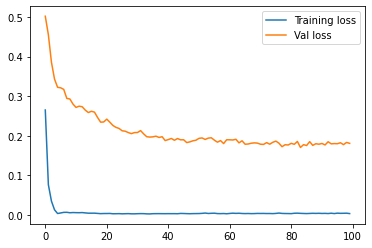

In [61]:
plt.plot(train_hist, label="Training loss")
plt.plot(val_hist, label="Val loss")
plt.legend()
plt.show()